# Keras MNIST tutorial

https://elitedatascience.com/keras-tutorial-deep-learning-in-python

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import optimizers

import numpy as np
np.random.seed(123)  # for reproducibility

### Load MNIST dataset

In [2]:
import os
from urllib import urlretrieve

def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# We then define functions for loading MNIST images and labels.
# For convenience, they also download the requested files if needed.
import gzip

def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the inputs in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    # The inputs are vectors now, we reshape them to monochrome 2D images,
    # following the shape convention: (examples, channels, rows, columns)
    data = data.reshape(-1, 1, 28, 28)
    # The inputs come as bytes, we convert them to float32 in range [0,1].
    # (Actually to range [0, 255/256], for compatibility to the version
    # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
    return data / np.float32(256)

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the labels in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    # The labels are vectors of integers now, that's exactly what we want.
    return data

In [3]:
X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [4]:
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(60000, 1, 28, 28)
(60000,)
(10000, 1, 28, 28)
(10000,)


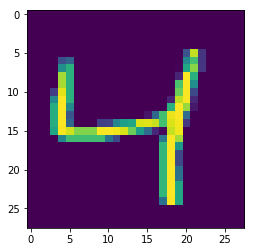

In [5]:
plt.imshow(X_train[2][0])

In [6]:
print X_train.shape
print X_test.shape

(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [7]:
# Convert to float32 and normalise to range [0,1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

## Convert labels to 10 distinct class labels (one-hot)

In [8]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [9]:
print Y_train.shape
print y_train[:2]
print Y_train[:2]

(60000, 10)
[5 0]
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


# Step 7. Define model architecture

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                 data_format="channels_first",input_shape=(1,28,28)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 24, 32)        7520      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5760)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               737408    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [14]:
adm = optimizers.Adam(lr=0.01, decay=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=adm, metrics=['accuracy'])

# Step 9. Fit model on training data

In [15]:
samples = X_train.shape[0]
print "using "+str(samples)+" samples"
history = model.fit(X_train[:samples], Y_train[:samples], 
          batch_size=32, epochs=12, verbose=1)

using 60000 samples
Epoch 1/12
60000/60000 [==============================] - 283s - loss: 14.5406 - acc: 0.0975   
Epoch 2/12
60000/60000 [==============================] - 288s - loss: 14.5460 - acc: 0.0975   
Epoch 3/12
60000/60000 [==============================] - 287s - loss: 14.5460 - acc: 0.0975   
Epoch 4/12
60000/60000 [==============================] - 286s - loss: 14.5466 - acc: 0.0975   
Epoch 5/12
60000/60000 [==============================] - 292s - loss: 14.5463 - acc: 0.0975   
Epoch 6/12
60000/60000 [==============================] - 288s - loss: 14.5487 - acc: 0.0974   
Epoch 7/12
60000/60000 [==============================] - 290s - loss: 14.5452 - acc: 0.0976   
Epoch 8/12
60000/60000 [==============================] - 293s - loss: 14.5455 - acc: 0.0976   
Epoch 9/12
60000/60000 [==============================] - 290s - loss: 14.5466 - acc: 0.0975   
Epoch 10/12
60000/60000 [==============================] - 292s - loss: 14.5466 - acc: 0.0975   
Epoch 11/12
60000/6

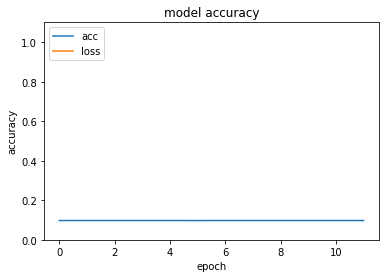

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
axes = plt.gca()
axes.set_ylim([0,1.1])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'loss'], loc='upper left')
plt.show()

# Step 10. Evaluate model on test data

In [14]:
score = model.evaluate(X_test, Y_test, verbose=1)

 9984/10000 [============================>.] - ETA: 0s

In [15]:
print score

[0.069513487902516505, 0.9778]
